# US County Network Analysis

## Goals

### 1. Construct a graph of the US based on county geolocations and with neighboring counties as edges.

### 2. Visualize counties' number of infected cases over time.

### 3. Identify holes in given dataset, where we do not have good enough case reporting.

In [1]:
find_holes = True

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import git
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [3]:
def correct_FIPS(fips):
    # We need to add back the leading zero to some of the FIPS codes
    # since they were removed when loaded them as floats
    fips = str(int(fips))
    if len(fips) == 4:
        fips = '0' + fips
    return fips

In [4]:
# Geographic and population centers for each county in US.
raw_county_centers = pd.read_csv(f"{homedir}/data/us/geolocation/county_centers.csv")
raw_county_centers['fips'] = raw_county_centers['fips'].apply(correct_FIPS)

In [5]:
raw_county_centers.head()

,fips,clon00,clat00,clon10,clat10,pclon00,pclat00,pclon10,pclat10
0,01001,-86.577176,32.523283,-86.644490,32.536382,-86.501832,32.500323,-86.494165,32.500389
1,01003,-87.748260,30.592781,-87.746067,30.659218,-87.760540,30.565383,-87.762381,30.548923
2,01005,-85.331312,31.856515,-85.405456,31.870670,-85.306746,31.847869,-85.310038,31.844036
3,01007,-87.123243,33.040054,-87.127148,33.015893,-87.127019,33.025947,-87.127659,33.030921
4,01009,-86.554768,33.978461,-86.567246,33.977448,-86.582617,33.962601,-86.591491,33.955243


In [6]:
# Specify `latin-1` encoding here b/c following link
# https://stackoverflow.com/questions/5552555/unicodedecodeerror-invalid-continuation-byte
fips_to_county_name = pd.read_csv(f"{homedir}/data/us/processing_data/fips_key.csv", encoding='latin-1')
fips_to_county_name['FIPS'] = fips_to_county_name['FIPS'].apply(correct_FIPS)
fips_to_county_name.head()

,FIPS,MSA/PMSA NECMA,ST,COUNTY
0,01001,5240,AL,Autauga County
1,01003,5160,AL,Baldwin County
2,01005,0,AL,Barbour County
3,01007,0,AL,Bibb County
4,01009,1000,AL,Blount County


In [7]:
# Make sure we have our full list of county centers because
# Our COVID datasets might not have reported numbers for some counties
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html
# https://stackoverflow.com/questions/26645515/pandas-join-issue-columns-overlap-but-no-suffix-specified
county_centers = fips_to_county_name[["FIPS", "COUNTY"]].rename(
    {'FIPS': 'fips', 'COUNTY': 'County Name'}, axis='columns'
    ).join(
        raw_county_centers.set_index('fips'), on=['fips'], how='outer'
    )
# There are duplicate entries of the same fips id, so remove those
county_centers = county_centers.drop_duplicates(subset="fips", keep="last")
county_centers.head(5)

,fips,County Name,clon00,clat00,clon10,clat10,pclon00,pclat00,pclon10,pclat10
0.0,01001,Autauga County,-86.577176,32.523283,-86.644490,32.536382,-86.501832,32.500323,-86.494165,32.500389
1.0,01003,Baldwin County,-87.748260,30.592781,-87.746067,30.659218,-87.760540,30.565383,-87.762381,30.548923
2.0,01005,Barbour County,-85.331312,31.856515,-85.405456,31.870670,-85.306746,31.847869,-85.310038,31.844036
3.0,01007,Bibb County,-87.123243,33.040054,-87.127148,33.015893,-87.127019,33.025947,-87.127659,33.030921
4.0,01009,Blount County,-86.554768,33.978461,-86.567246,33.977448,-86.582617,33.962601,-86.591491,33.955243


In [8]:
# Confirmed Cases 
raw_confirmed_cases = pd.read_csv(f"{homedir}/data/us/frozen/confirmed_cases_3_25_2020.csv")
raw_confirmed_cases['countyFIPS'] = raw_confirmed_cases['countyFIPS'].apply(correct_FIPS)

# There are duplicate entries of the same county, so remove those
raw_confirmed_cases = raw_confirmed_cases.drop_duplicates(subset="countyFIPS", keep="last")

In [9]:
# confirmed_cases[confirmed_cases["State"] == "CA"].sample(5)
raw_confirmed_cases.head(5)

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
1,01001,Autauga County,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,4,6
2,01003,Baldwin County,AL,1,0,0,0,0,0,0,...,1,1,1,2,2,3,3,4,4,5
3,01009,Blount County,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
4,01011,Bullock County,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
5,01013,Butler County,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [10]:
# Drop the county name column from the confirmed cases table so we don't clash with the FIPs county name
# We only want to join on the FIPS ID since we know those must be equivalen 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html
confirmed_cases = raw_confirmed_cases.drop(columns=['County Name'])

In [11]:
## Changing Join Type from 'left' to 'inner' allows us to identify areas
## where we do not have good case reporting and general holes in our current dataset
join_type = 'inner' if find_holes is True else 'left'

In [12]:
# Join County Centers Table with Confirmed Cases Table
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html
# https://stackoverflow.com/questions/26645515/pandas-join-issue-columns-overlap-but-no-suffix-specified

# Change Join Type from 'left' to 'inner' to identify areas where we do not have good case reporting
combined = county_centers.rename(
    {'fips': 'countyFIPS'}, axis='columns'
    ).join(
        confirmed_cases.set_index('countyFIPS'), on='countyFIPS', how=join_type
    )

# Will also throw out Alaska and Hawaiians for viz reasons later (big L for Alaskans and Hawaiians, sorry)
# Use ~ for not or ! when using pandas Series or DataFrames
# Use pd.Series.isin() here to check membership because the resulting list shape remains the same
# Or else the two comparisons will return two different sized lists
combined = combined[~combined["State"].isin(["AK", "HI"])]

# Also for viz reasons, throwing out counties whose latitudes and longitudes don't make sense
combined = combined[(combined["clon10"].values >= -130) & (combined["clon10"].values <= -60)]
combined = combined[(combined["clat10"].values >= 20) & (combined["clat10"].values <= 50)]

In [13]:
# Note that we have NaN values for counties that we don't have reported cases for
combined.head(5)
# combined[combined["State"] == "CA"].sample(5)

,countyFIPS,County Name,clon00,clat00,clon10,clat10,pclon00,pclat00,pclon10,pclat10,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
0.0,01001,Autauga County,-86.577176,32.523283,-86.644490,32.536382,-86.501832,32.500323,-86.494165,32.500389,...,0,0,0,0,0,0,0,1,4,6
1.0,01003,Baldwin County,-87.748260,30.592781,-87.746067,30.659218,-87.760540,30.565383,-87.762381,30.548923,...,1,1,1,2,2,3,3,4,4,5
4.0,01009,Blount County,-86.554768,33.978461,-86.567246,33.977448,-86.582617,33.962601,-86.591491,33.955243,...,0,0,0,0,0,0,0,0,1,2
5.0,01011,Bullock County,-85.704915,32.098285,-85.717261,32.101759,-85.702783,32.114144,-85.701192,32.116327,...,0,0,0,0,0,0,0,0,0,2
6.0,01013,Butler County,-86.662232,31.735884,-86.681969,31.751667,-86.656062,31.771916,-86.653550,31.773539,...,0,0,0,0,0,0,0,0,1,1


### Observe that the counties with NaN values are ones that our current confirmed cases counties haven't been reported yet. These counties where we do not have good case reporting will probably require further analysis.

In [14]:
# Load geographic county neighbors
# As edges of our graph
raw_neighbor_counties = pd.read_csv(f"{homedir}/data/us/geolocation/neighborcounties.csv")
raw_neighbor_counties['orgfips'] = raw_neighbor_counties['orgfips'].apply(correct_FIPS)
raw_neighbor_counties['adjfips'] = raw_neighbor_counties['adjfips'].apply(correct_FIPS)

# If an edge pair is not found (i.e. not corresponding county FIPS in original dataset)
# Then throw the edge out
full_fips_lst = combined["countyFIPS"].to_list()
full_fips = set(full_fips_lst)

# Use pd.Series.isin() here to check membership because the resulting list shape remains the same
# Or else the two comparisons will return two different sized lists
neighbor_counties = raw_neighbor_counties[raw_neighbor_counties["orgfips"].isin(full_fips) & 
                                          raw_neighbor_counties["adjfips"].isin(full_fips)]

In [15]:
neighbor_counties.head()

,orgfips,adjfips,instate
0,01001,01021,1
1,01001,01047,1
2,01001,01051,1
3,01001,01085,1
4,01001,01101,1


In [16]:
# Turn pandas dataframe table into list of tuples
# - https://stackoverflow.com/questions/36518027/pandas-creating-new-data-frame-from-only-certain-columns
# So we can pass into network x and build our graph
# - https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html

# NOTE: df[["col1", "col2"]] does not actually copy data itself, just creates a separate view (i.e. like reference)
county_edges = list(neighbor_counties[["orgfips","adjfips"]].to_records(index=False))
G = nx.Graph()

# Note: Try to add nodes in order first, for visualization purposes later
G.add_nodes_from(full_fips_lst)
G.add_edges_from(county_edges)

In [17]:
list(G.neighbors('01001'))

['01021', '01047', '01051', '01085', '01101']

In [18]:
# Let's visualize! Need to specify latitude and longitude coordinates as distance metric
# need a dictionary with nodes as keys and positions as values
# - https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx

# NOTE: df[["col1", "col2"]] does not actually copy data itself, just creates a separate view (i.e. like reference)

nodes = combined["countyFIPS"].to_list()
locs = list(combined[["clon10", "clat10"]].to_numpy())

location_dictionary = dict(zip(nodes, locs))


In [19]:
list(location_dictionary.items())[:10]

[('01001', array([-86.64449 ,  32.536382])),
 ('01003', array([-87.746067,  30.659218])),
 ('01009', array([-86.567246,  33.977448])),
 ('01011', array([-85.717261,  32.101759])),
 ('01013', array([-86.681969,  31.751667])),
 ('01015', array([-85.822513,  33.771706])),
 ('01017', array([-85.391812,  32.917943])),
 ('01019', array([-85.654242,  34.069515])),
 ('01021', array([-86.726627,  32.854059])),
 ('01023', array([-88.248887,  31.991008]))]

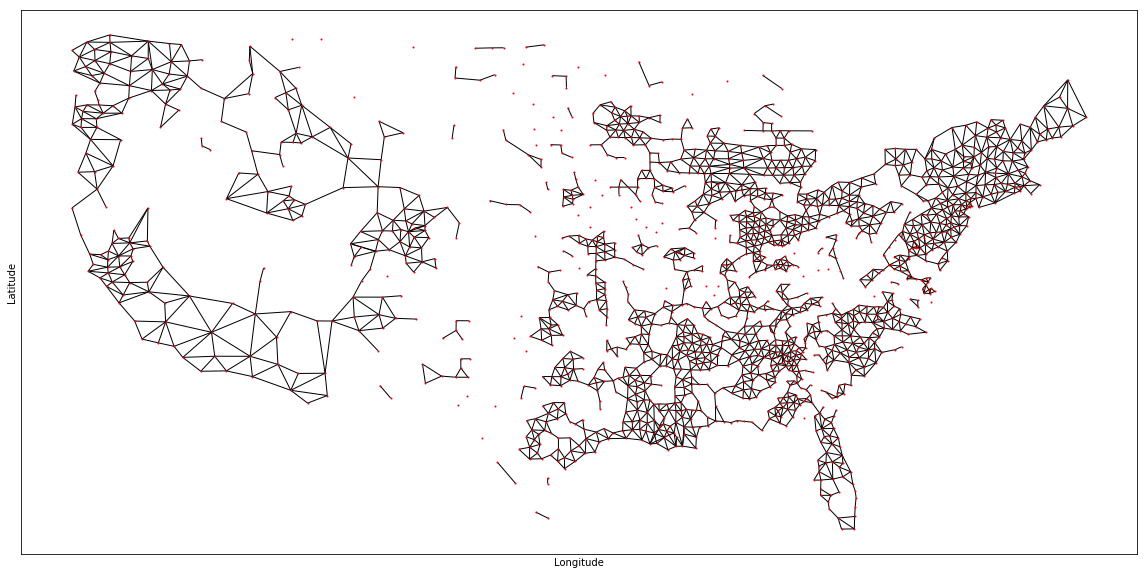

In [20]:
plt.figure(figsize=(20,10))
nx.drawing.nx_pylab.draw_networkx(
        G, 
        pos=location_dictionary,
        node_size=1,
        node_color='red',
        with_labels=False)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [21]:
# Now let's provide a size metric for our nodes based on our data
# Use some arbitrary days in March and see how the virus spreads
# Let's use confirmed case numbers
def plot_us_cases_with_date(dt):
    """
    dt: A string representing date of number of cases
        "3/10/2020" for example.
        
    https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx
    """
    county_case_numbers = combined[dt].to_list()
    plt.figure(figsize=(20,10))
    assert(len(county_case_numbers) == G.number_of_nodes())
    nx.drawing.nx_pylab.draw_networkx(
            G, 
            pos=location_dictionary,
            node_size=county_case_numbers,
            node_color='red',
            with_labels=False)
    plt.xlabel("Longitude", fontsize=20)
    plt.ylabel("Latitude", fontsize=20)
    plt.title("US Confirmed Cases as of %s" % dt, fontsize=24)
    plt.show()

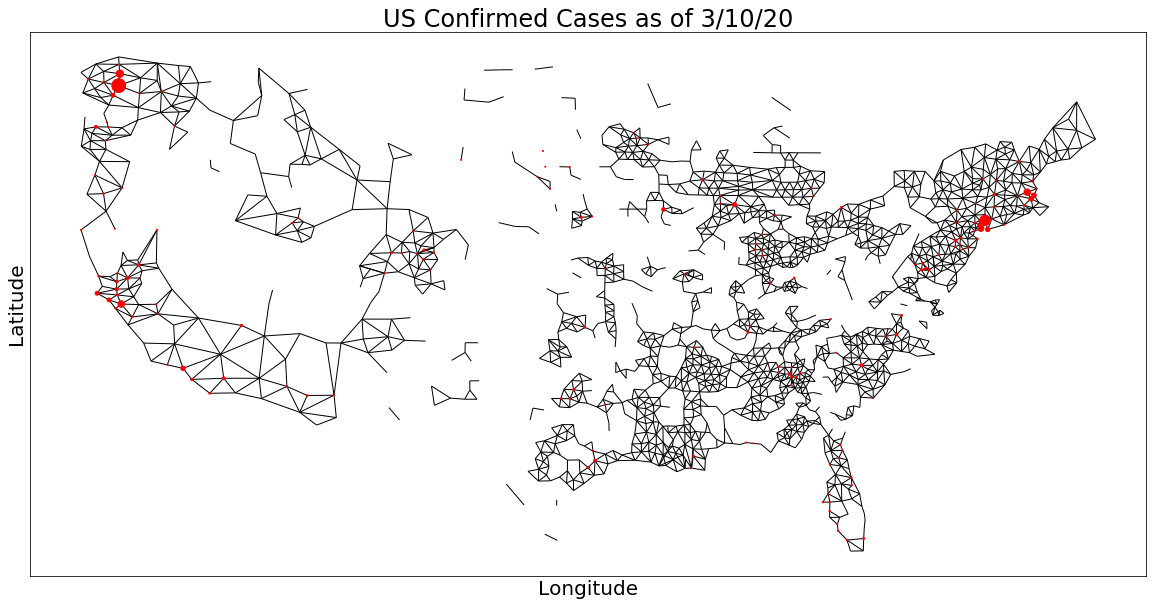

In [22]:
plot_us_cases_with_date("3/10/20")

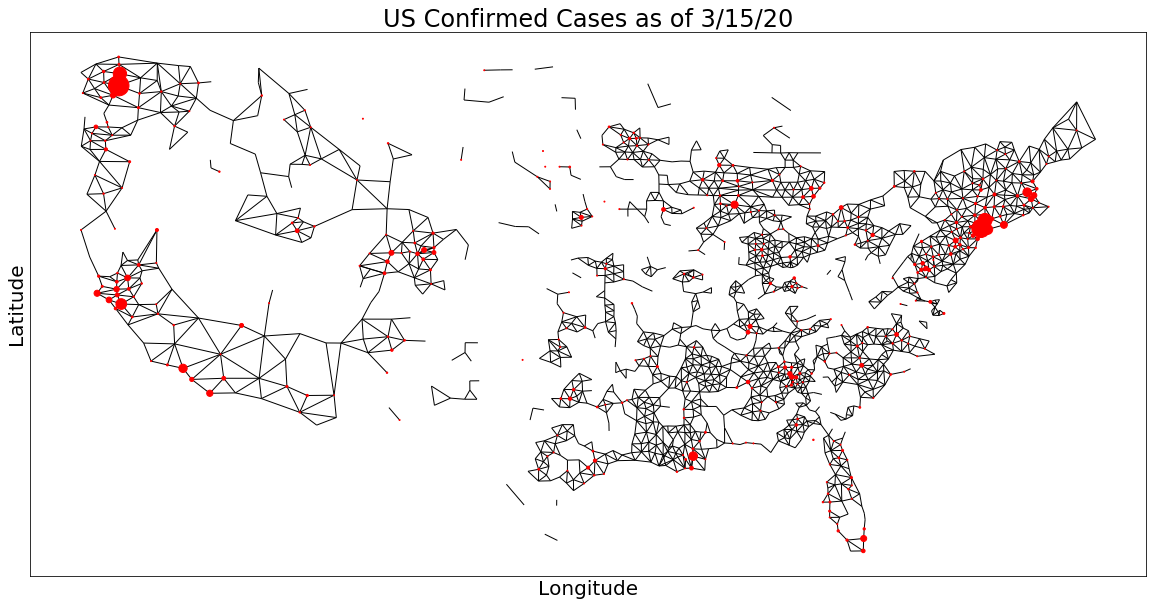

In [23]:
plot_us_cases_with_date("3/15/20")

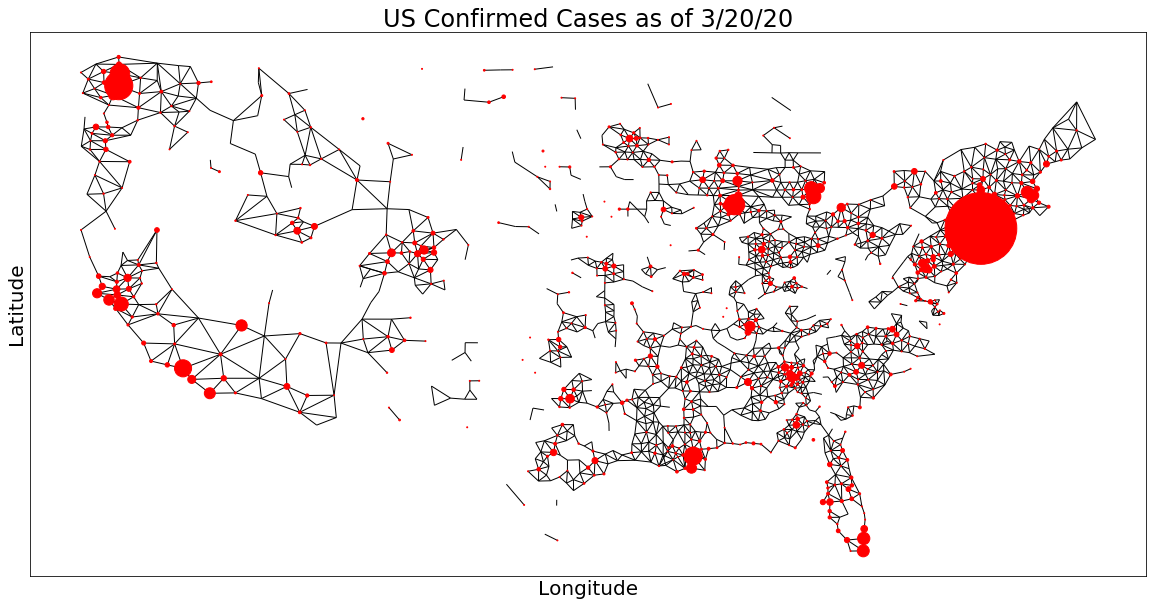

In [24]:
plot_us_cases_with_date("3/20/20")

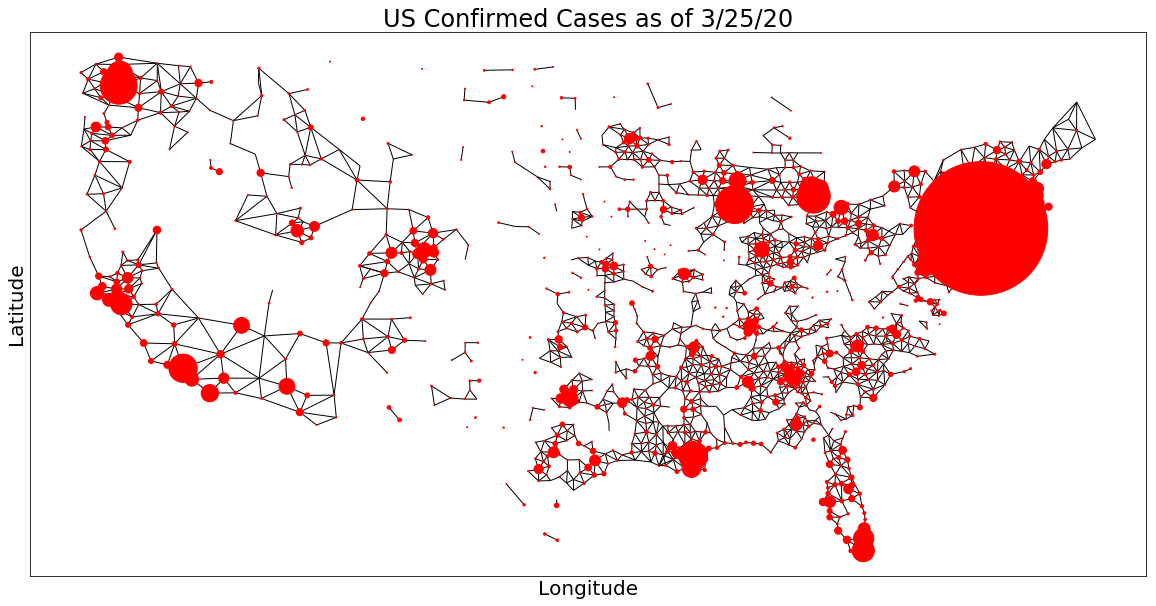

In [25]:
plot_us_cases_with_date("3/25/20")

In [26]:
combined.sort_values(by=["3/25/20"], ascending=False).head(10)

,countyFIPS,County Name,clon00,clat00,clon10,clat10,pclon00,pclat00,pclon10,pclat10,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
1875.0,36061,New York County,-73.973533,40.769656,-73.970174,40.776557,-73.964923,40.780432,-73.966303,40.777958,...,814,2009,3954,5151,8115,9654,12339,14776,17856,23112
1904.0,36119,Westchester County,-73.794013,41.057167,-73.745912,41.152770,-73.805386,41.039278,-73.804532,41.040536,...,380,538,798,1091,1385,1873,2894,3891,4691,5944
1874.0,36059,Nassau County,-73.602538,40.715949,-73.589384,40.729687,-73.601185,40.715749,-73.602242,40.716587,...,131,183,372,754,1234,1900,2442,2869,3285,3914
1896.0,36103,Suffolk County,-73.026232,40.833314,-72.692218,40.943554,-73.119032,40.820237,-73.113775,40.821924,...,84,116,178,371,662,1034,1458,1880,2260,2735
619.0,17031,Cook County,-87.767817,41.837649,-87.645455,41.894294,-87.752517,41.864508,-87.757714,41.865937,...,107,178,278,411,548,805,922,1194,1418,1904
2991.0,53033,King County,-122.196851,47.548745,-121.832375,47.493554,-122.236380,47.549353,-122.229983,47.548320,...,562,562,693,793,934,1040,1170,1277,1359,1577
1326.0,26163,Wayne County,-83.197950,42.337237,-83.261953,42.284664,-83.200595,42.340340,-83.217933,42.332610,...,17,23,119,216,349,477,638,873,1121,1389
1888.0,36087,Rockland County,-74.014963,41.124995,-74.024772,41.154785,-74.017033,41.127287,-74.019039,41.127623,...,22,30,53,101,262,455,592,671,968,1197
1162.0,22071,Orleans Parish,-90.059011,29.972754,-89.939007,30.068636,-90.050805,29.977005,-90.052840,29.972699,...,136,196,249,326,418,451,567,675,827,997
1790.0,34003,Bergen County,-74.059037,40.930457,-74.074522,40.959090,-74.057528,40.919202,-74.057383,40.918799,...,84,114,195,249,363,457,609,701,819,1206


## Future Directions

### 1. Include other edges (like airline travel routes)

### 2. Different metric of edges besides just neighboring geolocation.

### 3. Infection Spread Modeling Based on Edge Connections